<a href="https://colab.research.google.com/github/kiwibird35/geogfiles/blob/main/Copy_of_computational_issues_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/gisalgs/notebooks/blob/main/computational_issues-colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Computational Issues of Spatial Indexing

>"How long does getting thin take?" asked Pooh anxiously.  
>"About a week, I should think."  
>"But I can't stay here for a *week*!"  
>"You can *stay* all right, silly old Bear. It's getting you out which is so difficult."
>
><cite>A. A. Milne, Winnie-the-Pooh</cite>

>"And is all this common consciousness satisfied to use me as a black box? Since the black box works, is it unimportant to know what is inside? --- That doesn't suit me. I don't enjoy being a black box. I want to know what's inside."
>
><cite>Issac Asimov, Foundation and Earth</cite>


The computational time for trees can be broken down to at least two parts. The first is the time used to construct the tree, and then it is the time the tree is used to query. The overall time complexity of building a balanced k-D tree is $O(n \log_2 n)$. Searching a k-D only takes $O(\log_2 n)$ time in average when the tree is balanced. For unbalanced trees, however, we can imagine a worst case where points are always aligned on one branch of the node and in this case the search time is $O(n)$, as same as the linear search (though the actual time might be longer because traversing a tree takes more time than traversing a list or an array).

For point quadtrees, the cost of building a point quadtree is $O(n \log_4 n)$ when points are randomly sorted before they are inserted to the tree as we discussed above. A simple search on a balanced point quadtree has a time complexity of $O(\log_4 n)$ while the worst case would be $O(n)$ when the tree has only one node at each depth.

The above discussion, however, is theoretical. In practice, the actual computational time may follow the overall trend as predicted, but there are also many other factors that have significant impacts on the performance. For example, the physical time used can vary a lot depending on whether the program is compiled into binary code (as C/C++ programs) or interpreted (as Python and Java). Generally speaking, interpreted programming languages such as Python are less efficient in terms of the actual running time because the code must be interpreted line by line. It should be noted that Python or Java is not the interpreted language in its original meaning where the interpreter literally goes through line by line for every time it runs the program. Instead, they often use an immediate representation of the code that is compiled in binary that runs faster. Still, interpreted languages are still generally slower than compiled languages such as C/C++. The difference may not be noticeable for small data (and probably we don't really care), but the difference will be big when we deal with large data sets.

Aside from the programming language, how the algorithms are actually implemented will be a factor too. For example, the use of recursive functions, as convenient as it is, slows down the algorithm because of the repeated recursive function calls.



In [ ]:
# Linux, Max, or Colab
!uname -a
!lscpu

Linux 5717b34a21ff 5.4.104+ #1 SMP Sat Jun 5 09:50:34 PDT 2021 x86_64 x86_64 x86_64 GNU/Linux
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.142
BogoMIPS:            4400.28
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 

In [ ]:
# Windows
!wmic cpu get caption, deviceid, name, numberofcores, maxclockspeed

/bin/bash: wmic: command not found


## 1. Performance of query using k-D trees and point quadtrees

Here, we put our algorithms of k-D trees and point quadtrees into a test. We will simply compare the performance of using these trees, and we also compare them with the linear (brute-force) search approach. We test the performance by systematically controlling the size of the data and see how they catch up. The following are the packages that we will use.

In [ ]:
# This is only needed in Jupyter notebook when the github repos are not cloned
!git clone https://github.com/gisalgs/geom.git
!git clone https://github.com/gisalgs/indexing.git

Cloning into 'geom'...
remote: Enumerating objects: 314, done.
remote: Total 314 (delta 0), reused 0 (delta 0), pack-reused 314
Receiving objects: 100% (314/314), 57.03 KiB | 6.34 MiB/s, done.
Resolving deltas: 100% (177/177), done.
Cloning into 'indexing'...
remote: Enumerating objects: 170, done.
remote: Total 170 (delta 0), reused 0 (delta 0), pack-reused 170
Receiving objects: 100% (170/170), 33.41 KiB | 4.77 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [ ]:
from geom.point import *
from indexing.kdtree1 import *
from indexing.kdtree2a import *
from indexing.kdtree3 import *
from indexing.pointquadtree1 import *
from indexing.pointquadtree3 import *

from random import random, sample, uniform
import time
import copy

Now we write a function to do the testing. This function requires inputs of the number of points to be indexed in a tree, the number of points to be queried, and a boolean variable to specify if we need verbose (wordy) output.

In [ ]:
def test(npts, n, verbose=False):
    points = [Point(random(), random()) for i in range(npts)]
    time1 = time.time()
    kdt1 = kdtree(points)
    time2 = time.time()
    treet1 = time2-time1
    time1 = time.time()
    kdt2 = kdtree2(points)
    time2 = time.time()
    treet2 = time2-time1
    time1 = time.time()
    kdt3 = pointquadtree(points)
    time2 = time.time()
    treet3 = time2-time1

    t1 = 0 # time finding n points in kdtree
    t2 = 0 # time for balanced kdtree
    t3 = 0 # time for point quadtree
    t4 = 0 # time for linear search
    pp = sample(points, n)
    for p in pp:
        time1 = time.time()
        p1 = query_kdtree(kdt1, p)
        time2 = time.time()
        t1 = t1 + time2-time1

        time1 = time.time()
        p1 = query_kdtree(kdt2, p)
        time2 = time.time()
        t2 = t2 + time2-time1

        time1 = time.time()
        p1 = search_pqtree(kdt3, p)
        time2 = time.time()
        t3 = t3 + time2-time1

        time1 = time.time()
        for i in range(len(points)):
            if p == points[i]:
                break
        time2 = time.time()
        t4 = t4 + time2-time1

    if verbose:
        print("{0:7} | {1:6.3f} {2:6.3f} {3:6.3f} | {4:6.3f} {5:6.3f} {6:6.3f} | {7:6.3f}".format(
            npts, treet1, treet2, treet3, t1, t2, t3, t4))
    return npts, treet1, treet2, treet3, t1, t2, t3, t4

Here is a quick demo of this function in searching for 100 random points from 10,000 points. The test() function has an input called verbose which can be used to make the function run silently without printing anything. But printing out the current result can be a good feature if we want to know how the program progresses during time (for a long wait).

In [ ]:
t1 = test(10000, 100, True)

  10000 |  0.463  0.129  0.428 |  0.005  0.003  0.004 |  0.343


The above quick test clearly shows the efficiency of using the indexing method for query. It also shows that building the tree may need some significant amount of time.

Now we give it a more systematical test. More specifically, we use different numbers of points, ranging from 100,000 to **1,000,000**, with a step of 100,000. All the experiments were done on Now we give it a more systematical test. More specifically, we use different numbers of points, ranging from 100,000 to **1,000,000**, with a step of 100,000.

In [ ]:
time1 = time.time()
n = 100
alltime = []
for npts in range(100000, 1000001, 100000):
    alltime.append(test(npts, n, True))
time2=time.time()

 100000 |  4.859  1.161  3.454 |  0.006  0.003  0.004 |  3.126
 200000 |  7.937  2.912  7.243 |  0.007  0.004  0.005 |  7.643
 300000 | 12.698  4.633 12.015 |  0.007  0.004  0.005 | 11.117
 400000 | 17.347  6.574 15.454 |  0.007  0.004  0.005 | 13.839
 500000 | 21.294  8.752 19.816 |  0.007  0.005  0.006 | 19.881
 600000 | 26.253 10.281 26.247 |  0.008  0.004  0.006 | 23.516
 700000 | 32.323 12.813 29.117 |  0.008  0.004  0.006 | 27.964
 800000 | 36.911 14.333 33.895 |  0.007  0.004  0.006 | 32.772
 900000 | 40.511 17.152 40.291 |  0.007  0.004  0.006 | 31.231
1000000 | 45.364 18.669 44.070 |  0.007  0.004  0.006 | 37.429


The following code reports some numbers, including the total time in minutes and the time used on tree, where almost all of that time are used to construct the tree (so using the tree doesn't take much time).

In [ ]:
t1 = (time2-time1)/60
t2 = sum([sum(alltime[i][1:]) for i in range(len(alltime))])/60
t3 = sum([sum(alltime[i][1:7]) for i in range(len(alltime))])/60
t4 = sum([sum(alltime[i][1:4]) for i in range(len(alltime))])/60
print('total computing time: {:.1f} minutes'.format(t1))
print('Total processing time: {:.1f} minutes'.format(t2))
print('Total time on trees: {:.1f} minutes'.format(t3))
print('Tree construction time: {:.1f} minutes'.format(t4))

total computing time: 13.3 minutes
Total processing time: 13.1 minutes
Total time on trees: 9.6 minutes
Tree construction time: 9.6 minutes


As a way of comparison, the following shows previous results on different platforms.

Intel Next Computing Unit 10 (released in 2020) with Intel Core i7-10710U CPU 1.10GHz and 16 GB RAM, running the iPython notebook on Ubuntu Linux 20.04 LTS:

```
 100000 |  1.920  0.828  2.066 |  0.005  0.003  0.004 |  2.368
 200000 |  4.247  1.914  3.836 |  0.005  0.003  0.003 |  5.215
 300000 |  6.216  3.260  6.228 |  0.005  0.003  0.004 |  8.613
 400000 |  8.719  4.391  9.310 |  0.006  0.003  0.004 | 12.813
 500000 | 11.204  5.569 11.880 |  0.005  0.003  0.004 | 14.315
 600000 | 14.169  6.801 14.790 |  0.005  0.003  0.004 | 18.673
 700000 | 16.430  8.005 17.451 |  0.006  0.003  0.004 | 19.009
 800000 | 19.018  9.822 18.863 |  0.006  0.003  0.004 | 24.452
 900000 | 22.156 11.036 23.006 |  0.006  0.003  0.004 | 26.543
1000000 | 24.699 12.680 24.078 |  0.006  0.003  0.004 | 28.464
```

Surface Pro 6 with 2.11 GHz Intel Core i7and 8 GB RAM, using the Jupyter iPython notebook on Windows 10:

```
 100000 |  2.594  1.091  2.524 |  0.000  0.000  0.016 |  3.250
 200000 |  6.809  2.719  5.968 |  0.000  0.000  0.000 |  8.220
 300000 | 12.339  4.629  8.893 |  0.001  0.001  0.000 | 10.954
 400000 | 15.386  5.906 12.799 |  0.047  0.001  0.000 | 15.611
 500000 | 19.815  7.579 16.616 |  0.016  0.000  0.016 | 18.221
 600000 | 24.587 10.533 21.079 |  0.016  0.000  0.000 | 23.317
 700000 | 29.092 12.926 24.468 |  0.001  0.000  0.000 | 24.379
 800000 | 28.180 12.628 21.286 |  0.000  0.001  0.000 | 26.054
 900000 | 30.781 14.205 26.176 |  0.000  0.000  0.017 | 31.078
1000000 | 34.803 16.431 29.153 |  0.000  0.001  0.016 | 34.575
```


Mid 2014 MacBook Pro with 2.6 GHz Intel Core i5 and 8 GB RAM:

```
 100000 |  3.508  1.600  4.014 |  0.008  0.004  0.005 |  3.660
 200000 |  8.407  2.853  7.150 |  0.006  0.004  0.005 |  7.057
 300000 | 11.624  4.477 10.934 |  0.006  0.004  0.005 |  9.613
 400000 | 16.723  6.327 15.328 |  0.007  0.004  0.005 | 13.463
 500000 | 22.370  8.158 18.752 |  0.007  0.004  0.005 | 17.582
 600000 | 26.293 10.046 23.697 |  0.007  0.004  0.005 | 20.960
 700000 | 30.832 12.099 28.383 |  0.008  0.004  0.006 | 24.593
 800000 | 37.189 14.227 32.229 |  0.008  0.004  0.005 | 27.305
 900000 | 40.909 16.261 34.749 |  0.008  0.004  0.005 | 35.873
1000000 | 46.114 19.159 41.113 |  0.008  0.004  0.006 | 35.620
```

We now plot the results for a better visualization of the difference in the performances. Here is a shot at the construction times used for different kinds of trees:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

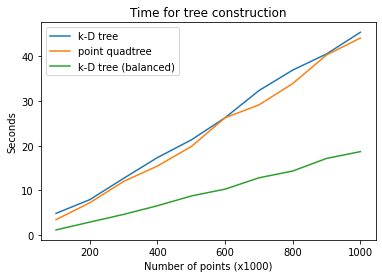

In [ ]:
x = [ alltime[i][0]/1000 for i in range(len(alltime))]
plt.plot(x, [ alltime[i][1] for i in range(len(alltime))], label='k-D tree')
plt.plot(x, [ alltime[i][3] for i in range(len(alltime))], label = 'point quadtree')
plt.plot(x, [ alltime[i][2] for i in range(len(alltime))], label='k-D tree (balanced)')
plt.legend(loc='upper left')
plt.xlabel('Number of points (x1000)')
plt.ylabel('Seconds')
plt.title('Time for tree construction')
plt.show()

The benefit of using the tree for query is obvious:

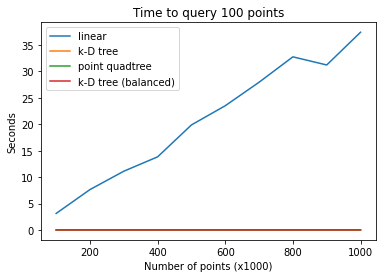

In [ ]:
plt.plot(x, [ alltime[i][7] for i in range(len(alltime))], label='linear')
plt.plot(x, [ alltime[i][4] for i in range(len(alltime))], label='k-D tree')
plt.plot(x, [ alltime[i][6] for i in range(len(alltime))], label='point quadtree')
plt.plot(x, [ alltime[i][5] for i in range(len(alltime))], label='k-D tree (balanced)')
plt.legend(loc='upper left')
plt.xlabel('Number of points (x1000)')
plt.ylabel('Seconds')
plt.title('Time to query 100 points')
plt.show()

The trend of using the tree across the three trees is not clear based on the test we just did, but we can still see from below that the balanced k-D tree is clearly positioned at the bottom of the three curves, showing the efficiency of the balanced tree.

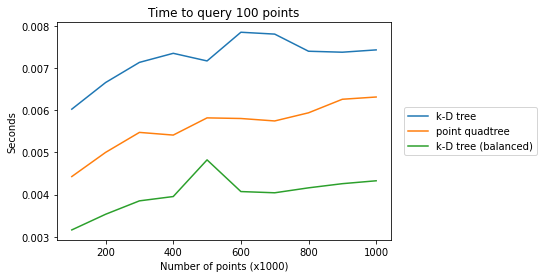

In [ ]:
plt.plot(x, [ alltime[i][4] for i in range(len(alltime))], label='k-D tree')
plt.plot(x, [ alltime[i][6] for i in range(len(alltime))], label='point quadtree')
plt.plot(x, [ alltime[i][5] for i in range(len(alltime))], label='k-D tree (balanced)')
plt.legend(loc='upper left')
plt.xlabel('Number of points (x1000)')
plt.ylabel('Seconds')
plt.title('Time to query 100 points')
plt.legend(loc='right', bbox_to_anchor=(1.45, 0.5))
plt.show()

## 2. Performance of orthogonal range search

We first define a few functions to make it convenient for testing different cases.

A note on changes: The textbook has the following line to create random points.

`randpoints0 = [Point(randrange(xmin, xmax), randrange(ymin, ymax)) for i in range(npts)]`

However, `randrange` will only return integers which will likely produce duplicated points. Here we write a new function called `rand_point` that uses `random.uniform` to generate random points.

In [ ]:
# A rectangle is defined as [ [xmin, xmax], [ymin, ymax]]

def in_rect(p, rect):
    x, y = p.x, p.y
    if not (rect[0][0]>x or rect[0][1] < x or rect[1][0]>y or rect[1][1] < y):
        return True
    return False

def rectangular_linear(points, rect):
    l = []
    for p in points:
        if in_rect(p, rect):
            l.append(p)
    return l

def rand_point(rect):
    '''generates a random point within a rect'''
    x = uniform(rect[0][0], rect[0][1])
    y = uniform(rect[1][0], rect[1][1])
    return Point(x, y)

def test_rect_find(w=10, h=10, rect=[[10,1000], [10,1000]], npts=100, n_query=10):
    """
    Repeats n_query times, based on npts points.
    Points are random in a area with both x and y ranging  from 10 to 1000.

    Uses a balanced k-D tree.
    Same set of points are used for n_query times.
    Each time, find points in a tree of npts points in a rectangle of w wide and h high.
    The rectangle does not go out of the range of x and y.

    Returns times of using the k-D tree and linear search, respectively.
    The time is averaged per query.
    """
    randpoints0 = [rand_point(rect) for i in range(npts)]
    randpoints = copy.deepcopy(randpoints0)
    kdt = kdtree2(randpoints0)

    times = []
    for i in range(n_query):
        x1 = uniform(rect[0][0], rect[0][1]-w)
        y1 = uniform(rect[1][0], rect[1][1]-h)
        rect_target = [ [x1, x1+w], [y1, y1+h] ]
        t1 = time.time()
        found = []
        range_query_orthogonal(kdt, rect_target, found)
        t2 = time.time()
        found2 = rectangular_linear(randpoints, rect_target) # linear search
        t3 = time.time()
        times.append( (t2-t1, t3-t2))
    return sum([t[0] for t in times])/float(n_query), sum([t[1] for t in times])/n_query

Here is an example of using it:

In [ ]:
test_rect_find(20, 20, npts=100000)

(0.00022327899932861328, 0.034420204162597653)

We hypothesize that using a k-D tree will help rectangular query, but the increase of the rectangle size will increase the time used to query. We test two things here:

1. when will the additional computation caused by the increase of the rectangle exceed the efficiency of using a k-D tree?
2. what is the impact of increasing the problem size (total number of points)?

We test the average of time used for each query for each configuration. The following code will take some significant time to run. It will be important to let the computer run, with power plugged in, and do not disturb it with other heavy lifting tasks such as watching movies or even gaming. We will be better off by making lunch or doing some workouts while letting the computer to finish.

In [ ]:
results = []
for npts in range(100000, 1000001, 100000):
    for w in [25, 50, 100, 200, 400, 600, 800]:
        x = test_rect_find(w, w, npts=npts)
        x = npts, w, x[0], x[1]
        results.append(x)

for r in results:
    print(r)

(100000, 25, 0.0003405570983886719, 0.035200881958007815)
(100000, 50, 0.0008212804794311523, 0.03446352481842041)
(100000, 100, 0.002928924560546875, 0.036293411254882814)
(100000, 200, 0.01163311004638672, 0.03748335838317871)
(100000, 400, 0.04210760593414307, 0.04346864223480225)
(100000, 600, 0.09483802318572998, 0.049257445335388186)
(100000, 800, 0.16867280006408691, 0.05467293262481689)
(200000, 25, 0.0005565881729125977, 0.06623139381408691)
(200000, 50, 0.0016018152236938477, 0.07116692066192627)
(200000, 100, 0.005743789672851563, 0.07001874446868897)
(200000, 200, 0.021563911437988283, 0.07252850532531738)
(200000, 400, 0.08541381359100342, 0.08441414833068847)
(200000, 600, 0.1916895627975464, 0.09638986587524415)
(200000, 800, 0.3385585069656372, 0.10698549747467041)
(300000, 25, 0.0007438421249389649, 0.09844057559967041)
(300000, 50, 0.0023679018020629885, 0.09486532211303711)
(300000, 100, 0.008715510368347168, 0.10496771335601807)
(300000, 200, 0.032955598831176755, 0

Please note there is a reason the above code is used to printout the tedious results. One of the questions for this module asks for a program that can be used to compute the total time of the above experiment based on the above output. This will be the total time used on the computer to produce this tutorial and it will be an interesting point to see how each of our own computer fares with this NUC 10.


## <font color="red">Question 1</font>

The above code does not report the total time. We can probably go back and re-run the code to get the total time, but we will have to wait another round. Luckily, we did print out the time returned by the `test_rect_find` function, which tell us the average time for each query. The printout is formatted in a specific way and we can definitely utilize that to get the total time.

The goal here is to compute the total time used in the above experiment. You should not redo the experiment. Instead, use the results printed. For example, the first two lines of the results may look like this:

```
(100000, 25, 0.00013082027435302735, 0.015203642845153808)
(100000, 50, 0.0003963470458984375, 0.015846920013427735)
```

and we can simply add a comma at the end of every line (except the last) and then put it in a pair of brackets. We then assign it to a variable:

```
myresults = [
(100000, 25, 0.00013082027435302735, 0.015203642845153808),
(100000, 50, 0.0003963470458984375, 0.015846920013427735)
```

This will create a valid Python data structure that allows us to do necessary calculation. Please also note that the time reported here is the average time per query, so it is important to account for the number of runs when computing the total time. You will need to examine the original code to see how the average is calculated.

In [ ]:
# TODO
#
#    Double click on this cell and write your code to answer the above question.
#    In the end, the total time should be printed out.
myresults = [
(100000, 25, 0.0003405570983886719, 0.035200881958007815),
(100000, 50, 0.0008212804794311523, 0.03446352481842041),
(100000, 100, 0.002928924560546875, 0.036293411254882814),
(100000, 200, 0.01163311004638672, 0.03748335838317871),
(100000, 400, 0.04210760593414307, 0.04346864223480225),
(100000, 600, 0.09483802318572998, 0.049257445335388186),
(100000, 800, 0.16867280006408691, 0.05467293262481689),
(200000, 25, 0.0005565881729125977, 0.06623139381408691),
(200000, 50, 0.0016018152236938477, 0.07116692066192627),
(200000, 100, 0.005743789672851563, 0.07001874446868897),
(200000, 200, 0.021563911437988283, 0.07252850532531738),
(200000, 400, 0.08541381359100342, 0.08441414833068847),
(200000, 600, 0.1916895627975464, 0.09638986587524415),
(200000, 800, 0.3385585069656372, 0.10698549747467041),
(300000, 25, 0.0007438421249389649, 0.09844057559967041),
(300000, 50, 0.0023679018020629885, 0.09486532211303711),
(300000, 100, 0.008715510368347168, 0.10496771335601807),
(300000, 200, 0.032955598831176755, 0.11441979408264161),
(300000, 400, 0.12990431785583495, 0.12453279495239258),
(300000, 600, 0.2860853910446167, 0.1398618459701538),
(300000, 800, 0.5174308538436889, 0.15988435745239257),
(400000, 25, 0.0009553670883178711, 0.13576688766479492),
(400000, 50, 0.0032418489456176756, 0.1322598934173584),
(400000, 100, 0.011526894569396973, 0.13704323768615723),
(400000, 200, 0.044194698333740234, 0.14607853889465333),
(400000, 400, 0.17360343933105468, 0.16554784774780273),
(400000, 600, 0.38757598400115967, 0.19184041023254395),
(400000, 800, 0.6864860773086547, 0.21727914810180665),
(500000, 25, 0.0012326955795288086, 0.16228873729705812),
(500000, 50, 0.00413825511932373, 0.16911671161651612),
(500000, 100, 0.014332723617553712, 0.16900148391723632),
(500000, 200, 0.05502562522888184, 0.18560097217559815),
(500000, 400, 0.21639387607574462, 0.2089566707611084),
(500000, 600, 0.4846062421798706, 0.23481690883636475),
(500000, 800, 0.8565223693847657, 0.2654517889022827),
(600000, 25, 0.0013785839080810546, 0.2002696990966797),
(600000, 50, 0.004673528671264649, 0.19948840141296387),
(600000, 100, 0.017553329467773438, 0.21301848888397218),
(600000, 200, 0.06656107902526856, 0.216414475440979),
(600000, 400, 0.25943799018859864, 0.2535488843917847),
(600000, 600, 0.5814418315887451, 0.28294613361358645),
(600000, 800, 1.0347366333007812, 0.3216495752334595),
(700000, 25, 0.001548433303833008, 0.22858130931854248),
(700000, 50, 0.00547947883605957, 0.23370826244354248),
(700000, 100, 0.02095334529876709, 0.23460946083068848),
(700000, 200, 0.07740058898925781, 0.2574231863021851),
(700000, 400, 0.3077333927154541, 0.28710777759552003),
(700000, 600, 0.6895402908325196, 0.33165736198425294),
(700000, 800, 1.217804193496704, 0.3755007266998291),
(800000, 25, 0.0018121957778930663, 0.2636042356491089),
(800000, 50, 0.00617368221282959, 0.26979517936706543),
(800000, 100, 0.022948312759399413, 0.27623913288116453),
(800000, 200, 0.08804571628570557, 0.287245512008667),
(800000, 400, 0.35492839813232424, 0.3341665744781494),
(800000, 600, 0.7902978658676147, 0.3768876552581787),
(800000, 800, 1.4042447805404663, 0.42833192348480226),
(900000, 25, 0.0019783735275268554, 0.29433088302612304),
(900000, 50, 0.007235121726989746, 0.30701920986175535),
(900000, 100, 0.025778794288635255, 0.3160213232040405),
(900000, 200, 0.09926683902740478, 0.32715663909912107),
(900000, 400, 0.3918956518173218, 0.3770277500152588),
(900000, 600, 0.882020115852356, 0.4254038333892822),
(900000, 800, 1.5717053413391113, 0.47479298114776614),
(1000000, 25, 0.0022838354110717774, 0.3275598526000977),
(1000000, 50, 0.0077476978302001955, 0.33244707584381106),
(1000000, 100, 0.029084277153015137, 0.34730706214904783),
(1000000, 200, 0.1121171236038208, 0.36087651252746583),
(1000000, 400, 0.44198873043060305, 0.41275844573974607),
(1000000, 600, 0.986131739616394, 0.47921085357666016),
(1000000, 800, 1.751505160331726, 0.5389295816421509)
]
total = sum([sum(myresults[i][2:]) for i in range(len(myresults))]*10)

print(total)

335.5957512855534


Now, at this point, we have a lot of data in `results` to visualize. Here we show the dominating trends in the data using a subset of the results.

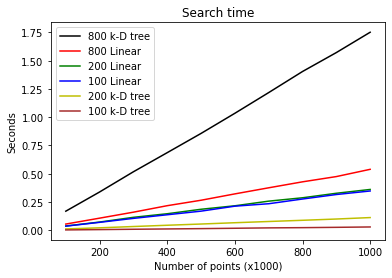

In [ ]:
x = [ r[0]/1000 for r in results if r[1]==25]
t100 = [ r[2] for r in results if r[1]==100]
t200 = [ r[2] for r in results if r[1]==200]
t800 = [ r[2] for r in results if r[1]==800]
tl100 = [ r[3] for r in results if r[1]==100]
tl200 = [ r[3] for r in results if r[1]==200]
tl800 = [ r[3] for r in results if r[1]==800]

plt.plot(x, t800, color='k', label='800 k-D tree')
plt.plot(x, tl800, color='r', label='800 Linear')
plt.plot(x, tl200, color='g', label='200 Linear')
plt.plot(x, tl100, color='b', label='100 Linear')
plt.plot(x, t200, color='y', label='200 k-D tree')
plt.plot(x, t100, color='brown', label='100 k-D tree')

plt.legend(loc='upper left')
plt.xlabel('Number of points (x1000)')
plt.ylabel('Seconds')
plt.title('Search time')
plt.show()

In the above figure, the numbers in the legend refer to the size of the rectangle. We always use a squire in this test and the overall area is a 990x990 box. It appears that a rectangle of 800x800 takes most of the entire area and therefore takes a lot of time to get the points, more than linear search. However, for other rectangle sizes, the use of k-D tree seems to be beneficial.

We now examine the result from another perspective: how the size of the rectangle affects performance? We first pull out the results for the data of 1,000,000 points.

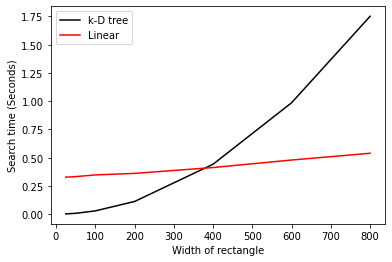

In [ ]:
xs = []
ttree = []
tlinear = []
for r in results:
    if r[0]==1000000:
        xs.append(r[1])
        ttree.append(r[2])
        tlinear.append(r[3])

plt.plot(xs, ttree, color='k', label='k-D tree')
plt.plot(xs, tlinear, color='r', label='Linear')

plt.legend(loc='upper left')
plt.xlabel('Width of rectangle')
plt.ylabel('Search time (Seconds)')
plt.show()

The above figure is interesting: the use of k-D tree will become more computationally expensive when the size of rectangle is greater than about 500x500. How about other settings? Below, we try to pull all the results and re-organize them into a different structure. More specifically, we use a Python dictionary to organize. We use the data size (number of points) as the key to build the dictionary. For each key, we store three lists: the lists of rectangle sizes, time used by the k-D tree, and by the linear search.

In [ ]:
new_data = {}
sizes = range(100000, 1000001, 100000)
for w in sizes:
    new_data[w] = [[], [], []]

for r in results:
    w = r[0]
    new_data[w][0].append(r[1]/100)
    new_data[w][1].append(r[2])
    new_data[w][2].append(r[3])

With the newly organized results (as saved in new_data), we can now put all the lines together in one figure. This is not necessarily the best way to draw things, but a quick way.

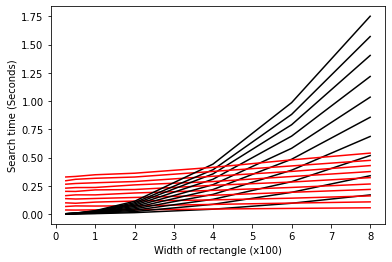

In [ ]:
for w in sizes:
    plt.plot(new_data[w][0], new_data[w][1], color='k', label='k-D tree')
    plt.plot(new_data[w][0], new_data[w][2], color='r', label='Linear')

#plt.legend(loc='upper left')
plt.xlabel('Width of rectangle (x100)')
plt.ylabel('Search time (Seconds)')
plt.show()

The above figure is quick and fun, but not very much useful in reading it. The following illustrate is a remake using the same data and is stunningly effective in showing the intrinsic trends!

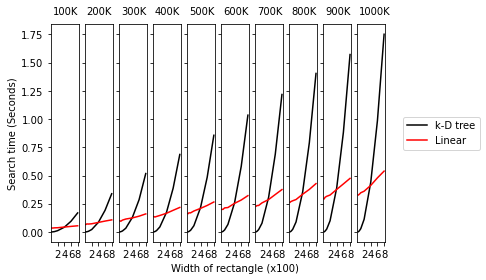

In [ ]:
numsubplots = len(sizes)
fig, axs = plt.subplots(1, numsubplots, sharey=True)
panel_label_y = 1.1 * max(new_data[sizes[-1]][1]) # get Y position of panel labels

i = 0
for w in sizes:
    axs[i].plot(new_data[w][0], new_data[w][1], color='k', label='k-D tree')
    axs[i].plot(new_data[w][0], new_data[w][2], color='r', label='Linear')
    #plt.xticks([sizes[j]/100 for j in range(len(sizes)) if j%3==0])
    axs[i].xaxis.set_ticks([2, 4, 6, 8])
    axs[i].text(0.5, panel_label_y, str(w//1000)+'K')
    i += 1

axs[5].set_xlabel('Width of rectangle (x100)')
axs[0].set_ylabel('Search time (Seconds)')
plt.legend(loc='right', bbox_to_anchor=(4.5, 0.5))
plt.show()

## 3. Performance of nearest neighbor search

Now we test the performance of nearest neighbor search using three methods: k-D tree, point quadtree, and linear search (`nn_linear`). Here are some necessary functions for the testing.

In [ ]:
def nn_linear(p, points, n_neighbor=10):
    '''Linear search, or exhaustive search, or brute-force search'''
    dist = [p.distance(z) for z in points]
    Z1 = [(points[i], dist[i]) for i in range(len(dist))]
    Z1.sort(key=lambda Z1: Z1[1])
    Z1 = Z1[:n_neighbor]
    return Z1

def test_nn_find(rect=[[10,1000], [10,1000]], n_neighbor=10, npts=100, n_query=10):
    randpoints0 = [rand_point(rect) for i in range(npts)]
    randpoints = copy.deepcopy(randpoints0)
    pqt = pointquadtree(randpoints0)
    kdt = kdtree2(randpoints0)

    times = []
    for i in range(n_query):
        p = rand_point(rect)
        t1 = time.time()
        nnp1 = kdtree_nearest_neighbor_query(kdt, p, n_neighbor)
        t2 = time.time()
        nnp2 = pq_nearest_neighbor_query(pqt, p, n_neighbor)
        t3 = time.time()
        nnp3 = nn_linear(p, randpoints, n_neighbor)
        t4 = time.time()
        times.append((t2-t1, t3-t2, t4-t3))
    return sum([t[0] for t in times])/n_query, sum([t[1] for t in times])/n_query, sum([t[2] for t in times])/n_query


In [ ]:
test_nn_find(n_neighbor=25, npts=10000)

(0.000521993637084961, 0.00264894962310791, 0.010713863372802734)

Now we test a few configurations. We search for up to 800 nearest points (note this is not the same as 800 in the previous experiment where 800 is the width of the rectangle). In our tests below, 800 points is really a small portion of all points. More on this later.

In [ ]:
results_nn = []
for npts in range(200000, 1000001, 200000):
    for n in [25, 50, 100, 200, 400, 800]:
        x = test_nn_find(n_neighbor=n, npts=npts)
        x = npts, n, x[0], x[1], x[2]
        results_nn.append(x)
        print(x)

(200000, 25, 0.0005255937576293945, 0.002486562728881836, 0.5307612895965577)
(200000, 50, 0.0011348485946655273, 0.0038878679275512694, 0.4883486986160278)
(200000, 100, 0.002982020378112793, 0.01742854118347168, 0.48369503021240234)
(200000, 200, 0.008382105827331543, 0.04667503833770752, 0.4966383695602417)
(200000, 400, 0.032259202003479, 0.16183140277862548, 0.49212400913238524)
(200000, 800, 0.1000565767288208, 0.5261512517929077, 0.4929659366607666)
(400000, 25, 0.0005854129791259766, 0.003473830223083496, 1.0723907470703125)
(400000, 50, 0.0011899232864379882, 0.006532597541809082, 1.070043158531189)
(400000, 100, 0.0030403375625610352, 0.016001415252685548, 1.0803653717041015)
(400000, 200, 0.009621024131774902, 0.04577512741088867, 1.0741769075393677)
(400000, 400, 0.02603459358215332, 0.324254584312439, 1.076483392715454)
(400000, 800, 0.11160397529602051, 0.6072548627853394, 1.0873864412307739)
(600000, 25, 0.0005038738250732422, 0.0037279844284057615, 1.650157380104065)
(6

## <font color="red">Question 2</font>

Plot a figure that can show the time complexity trend of nearest neighbor search using a tree  (either a k-D tree or a point quadtree will be fine) from the above experiment. Again, we don't need to re-run the code. Instead, use the results printed above , where the first two lines of the printout look like this:


```
(200000, 25, 0.0004232645034790039, 0.0017875194549560546, 0.3703118324279785),
(200000, 50, 0.0008641958236694336, 0.0032688140869140624, 0.37016251087188723)
```

We did not discuss nearest neighbor search the class in this semester, but the algorithms are similar to those of orthogonal and circular searches. Please refer to Sections 5.1.3 and 6.2 of *GIS Algorithms* for more detailed discussions about nearest neighbor search.


In [ ]:
# TODO
#
#    Double click on this cell and write your code to answer the above question.


x = [ r[0]/1000 for r in results_nn if r[1]==25]
t100 = [ r[2] for r in results_nn if r[1]==100]
t200 = [ r[2] for r in results_nn if r[1]==200]
t800 = [ r[2] for r in results_nn if r[1]==800]
tl100 = [ r[3] for r in results_nn if r[1]==100]
tl200 = [ r[3] for r in results_nn if r[1]==200]
tl800 = [ r[3] for r in results_nn if r[1]==800]

plt.plot(x, t800, color='k', label='800 k-D tree')
plt.plot(x, tl800, color='r', label='800 Linear')
plt.plot(x, tl200, color='g', label='200 Linear')
plt.plot(x, tl100, color='b', label='100 Linear')
plt.plot(x, t200, color='y', label='200 k-D tree')
plt.plot(x, t100, color='brown', label='100 k-D tree')

plt.legend(loc='upper left')
plt.xlabel('Number of points (x1000)')
plt.ylabel('Seconds')
plt.title('Search time')
plt.show()

NameError: ignored

Generally, finding 800 nearest neighbors of a point on a tree of 900,000 points is a piece of cake! However, before we can be more conclusive, there are more tests to do: what is the downside of using a k-D tree? We know that constructing such a tree takes time, and from the previous experiments, we also know that at some point the use of a k-D tree for searching may be excessive because we will have to traverse the tree back and forth too many times that will be more than just using a linear search. Does this happen to the nearest neighbor search using k-D tree too? Here are some quick tests and these should give us some good ideas about the last point!

In [ ]:
print(test_nn_find(n_neighbor=10, npts=100000))
print(test_nn_find(n_neighbor=25, npts=100000))
print(test_nn_find(n_neighbor=10000, npts=100000))

(0.00027561187744140625, 0.0008544206619262695, 0.19142725467681884)
(0.0005954027175903321, 0.0031795263290405273, 0.23459722995758056)
(15.4989483833313, 49.307459235191345, 0.2525263071060181)


## <font color="red">Question 3</font>

In the output of the above code we should see something like this in each line:

```
(11.019792795181274, 29.53496918678284, 0.2186837911605835)
```

What does each of these three numbers mean? What can we learn from this result?

In [ ]:
# TODO
#
#    Double click on this cell and answer the above question here.




We can do more tests on a smaller tree:

In [ ]:
print(test_nn_find(n_neighbor=10, npts=250))
print(test_nn_find(n_neighbor=50, npts=250))
print(test_nn_find(n_neighbor=100, npts=250))
print(test_nn_find(n_neighbor=200, npts=250))

(0.00011029243469238282, 0.0002636432647705078, 0.00021393299102783202)
(0.0005986928939819336, 0.0012166976928710937, 0.00028355121612548827)
(0.0020723342895507812, 0.0035135030746459963, 0.00028672218322753904)
(0.003235149383544922, 0.003307962417602539, 0.00022432804107666015)
